# Importación de librerías

In [92]:
# API Yahoo
import yfinance as yf

# Data Viz
import matplotlib.pyplot as plt
import mplfinance as mpf
from IPython.display import display

# Funcionalidades
#timedelta es para diferencias de tiempo, date es una clase
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np

# SOLO PARA JUPYTER NB
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Definición de funciones

In [85]:
###########
# General #
###########

def get_prices(ticker, start=date.today()-timedelta(days=365), end=date.today()):
    """
    Dado un ticker, carga los datos de cotizaciones entre start_date y end_date
    Formato de fecha: YYYY-MM-DD
    Si no se especifica end_date, se inicializa como hoy por defecto.
    Es importante decir que el primer dato puede ser POSTERIOR al dado, pues puede haber empezado a cotizar después de la fecha proporcionada    
    """
    return yf.download(ticker, start=start, end=end, progress=False).dropna()

def get_info(ticker):
    """
    Dado un ticker, carga datos de la empresa.
    """
    return yf.Ticker(ticker).info

def repr_info(info, ticker, description=False):
    """
    Recibe un diccionario resultante de llamar a la función get_info() y  muestra por pantalla los datos más relevantes
    """
    # Datos más relevantes a elleción del programador
    info_d = {
        'general': ['country', 'website', 'industry', 'sector', 'fullTimeEmployees', 'dividendYield', 'beta', 'marketCap',  'currency', 'enterpriseValue', 'fiftyTwoWeekLow', 'fiftyTwoWeekHigh'],
        'financials': ['trailingPE', 'forwardPE', 'trailingEps', 'forwardEps', 'targetHighPrice', 'targetLowPrice', 'freeCashflow', 'operatingCashflow', 'earningsGrowth', 'revenueGrowth'],
        'margins': ['profitMargins', 'grossMargins', 'ebitdaMargins', 'operatingMargins'],
        'returns': ['returnOnAssets', 'returnOnEquity']
    }

    # Imprimo toda la info
    print(f'Información de la empresa: {ticker.upper()}')
    
    if description:
        print(f'Resumen: {info["longBusinessSummary"]}')

    not_seen = []
        
    for section in info_d:
        print('#'*40)
        print(f'\t\t-- {section.upper()} --')
        for data in info_d[section]:
            try:
                print(f'{data}: {info[data]}')
            except:
                not_seen.append(data)
        if section == 'general':
            print(f'1 Year Change %: {pct_change(ticker)}')
            print(f'5 Years CAGR: {cagr(ticker, start_date=date.today()-timedelta(days=365*5))}')
        print('\n')

    # Printeo si ha habido algún dato que no ha podido ser mostrado
    if len(not_seen) > 0: print(f'Los siguientes datos no se pudieron mostrar: {not_seen}')

def load_repr_info(ticker, desc=False):
    """
    Función auxiliar que llama a get_info y repr_info.
    Pide el ticker de la empresa y el booleano para la descripción
    IMPORTANTE: No acepta más de un ticker
    """
    repr_info(get_info(ticker), ticker, desc)

############
# Cálculos #
############
    
def pct_change(ticker, start_date=date.today()-timedelta(days=365), end_date=date.today()):
    """
    Dado un ticker, calcula el retorno si hubieramos invertido en la apertura del mercado
    del día start_date hasta el cierre del día actual.
    Formato de fecha: YYYY-MM-DD
    """
    
    # Descargar datos históricos desde start_date hasta end_date
    data = get_prices(ticker, start=start_date, end=end_date)
    
    initial_price = data['Open'].iloc[0]  # Precio de apertura en start_date
    last_price = data['Close'].iloc[-1]  # Precio de cierre actual
    percent_change = ((last_price - initial_price) / initial_price)
    
    return round(percent_change, 4)

def pct_change_from(data):
    """
    Dados unos datos precargados, calcula el retorno si hubieramos invertido en la apertura del mercado
    del primer día en los datos hasta el cierre del último día.
    Formato de fecha: YYYY-MM-DD
    """
    
    initial_price = data['Open'].iloc[0]  # Precio de apertura en start_date
    last_price = data['Close'].iloc[-1]  # Precio de cierre actual
    percent_change = ((last_price - initial_price) / initial_price)
    
    return round(percent_change, 4)

def cagr(ticker, start_date=None, end_date=None):
    """
    Obtiene el CAGR (Compound Annual Growth Rate) de una empresa.
    Para ello, toma los años enteros de diferencia desde el start_date hasta end_date, redondeando hacia abajo.
    Si no se especifica año, solo obtiene el pct de cambio de un año
    Formato de fecha: YYYY-MM-DD
    """
    if start_date is None:
        start_date = str(date.today() - timedelta(days=365))
    if end_date is None:
        end_date = str(date.today())
    
    # Normalizar el formato de las fechas si son cadenas
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, "%Y-%m-%d").date() if len(start_date) == 10 else datetime.strptime(start_date, "%Y-%m-%d")
    if isinstance(end_date, str):
        end_date = datetime.strptime(end_date, "%Y-%m-%d").date() if len(end_date) == 10 else datetime.strptime(end_date, "%Y-%m-%d")

    # Descargar datos históricos desde start_date hasta end_date
    data = get_prices(ticker, start=str(start_date), end=str(end_date))

    anyos = int(((end_date - start_date).days / 365))  # Años de diferencia, redondeando hacia abajo
    initial_price = data['Open'].iloc[0]  # Precio de apertura en start_date
    last_price = data['Close'].iloc[-1]  # Precio de cierre actual
    
    cagr = ((last_price / initial_price) ** (1 / anyos) - 1)
    return round(cagr, 4)

def cagr_from(data):
    """
    Obtiene el CAGR dado un dataset de cotizaciones
    Para ello, toma los años enteros de diferencia redondeando hacia abajo.
    """
    start_date = data.index[0]
    end_date = data.index[-1]
    anyos = int(((end_date-start_date).days/365)) # Anyos de diferencia, redondeando hacia abajo

    if anyos == 0:
        raise ZeroDivisionError('El dataset contiene menos de un año de datos, necesitas un mínimo de un 1 año')

    initial_price = data['Open'].iloc[0]  # Precio de apertura en start_date
    last_price = data['Close'].iloc[-1]  # Precio de cierre actual
    cagr = ((last_price / initial_price) ** (1 / anyos) - 1)

    return round(cagr, 4)

#################
# Visualización #
#################

def add_macd(data):
    """
    Función auxiliar para añadir el macd en el gráfico de la función plot().
    Recibe el dataframe de las cotizaciones.
    Las medias utilizadas en el macd o Moving Average Convergence Divergence son de longitud 9, 12 y 26.
    En el MACD: 
    Si la línea MACD está por encima de cero, tendencia bullish
    Si la línea MACD está por debajo de cero, tendencia bearish
    La estrategia básica suele combinar histograma y MACD, tal que, si el MACD sobresale del histograma:
    Por debajo del nivel cero, oportunidad de compra
    Por encima del nivel cero, oportunidad de venta
    """

    # Calcular el indicador MACD y el histograma
    exp12 = data['Close'].ewm(span=12, min_periods=0, adjust=False).mean() #ewm es media exponencial
    exp26 = data['Close'].ewm(span=26, min_periods=0, adjust=False).mean()
    macd = exp12 - exp26
    signal = macd.ewm(span=9, min_periods=0, adjust=False).mean()
    histogram = macd-signal

    # Añadimos los addplots
    apds = [mpf.make_addplot(histogram,type='bar',width=0.7,panel=1,
                             color='dimgray',alpha=1,secondary_y=False),
            mpf.make_addplot(signal,panel=1,color='orange',secondary_y=True)
           ]
    return apds

def relative_strength(prices, n=14):
    """
    Función que calcula el índice relativo de fuerza o RSI.
    Se ha obtenido ayuda bibliográfica para su diseño. Consulta: 
    https://github.com/matplotlib/mplfinance/blob/master/examples/indicators/mpf_rsi_demo.py
    """
    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)
    return rsi

def add_rsi(data):
    data['rsi'] = relative_strength(data['Close'],n=7)    
    apd = [mpf.make_addplot(data['rsi'], panel=1, color='lime',ylim=(10,90),secondary_y=True)]
    return apd

def plot(ticker, start_date=str(date.today()-timedelta(days=365)), end_date=str(date.today()), volume=False, 
         style='yahoo', title='', ylabel='', ylabel_lower='', savefig=None, type='candle', sma=(), info=False, macd=False, rsi=False):
    """
    Dada una fecha de inicio y una fecha de fin, realiza el gráfico de la cotización dentro de ese período.
    Si no hay fecha de fin, toma el último día de cotización. 
    Otros atributos:
    - volume: boolean
    - style= consult mpf.available_styles(), 'yahoo' is at default,
    - title= str,
    - ylabel= str,
    - ylabel_lower=str, 
    - savefig=str,
    - type = lines/candles
    - sma = tuple
    - info= boolean, muestra por pantalla información general de la empresa
    - macd= boolean, muestra el MACD
    - rsi = boolean, muestra el RSI.
    NOTA SOBRE INDICADORES: Por convención, la presencia de un indicador excluirá los demás, puedes plotear varios llamando varias veces al método plot
    Orden: macd > rsi > bollinger
    Formato de fecha: YYYY-MM-DD
    """
    # Obtener los datos de cotización utilizando yfinance
    data = get_prices(ticker, start=start_date, end=end_date)

    # Normalización
    if title=='': title = f'Cotización de {ticker}'
    if ylabel=='': ylabel='Price'
    if ylabel_lower=='': ylabel_lower='Volume'

    # Adición de ténicos y graficación
    if macd: 
        ap = add_macd(data) 
        if savefig is None:
            mpf.plot(data, type=type, addplot=ap, volume=volume, volume_panel=2, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, mav=(sma))
        else:
            mpf.plot(data, type=type, addplot=ap, volume=volume, volume_panel=2, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, savefig=savefig+'.png', mav=(sma))
    elif rsi:
        ap = add_rsi(data)
        if savefig is None:
            mpf.plot(data, type=type, addplot=ap, volume=volume, volume_panel=2, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, mav=(sma))
        else:
            mpf.plot(data, type=type, addplot=ap, volume=volume, volume_panel=2, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, savefig=savefig+'.png', mav=(sma))
    else:
        if savefig is None:
            mpf.plot(data, type=type, volume=volume, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, mav=(sma))
        else:
            mpf.plot(data, type=type, volume=volume, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, savefig=savefig+'.png', mav=(sma))
    if info:
        load_repr_info(ticker)

def plot_from(data, style='yahoo', title='', ylabel='', ylabel_lower='', savefig=None, type='candle', volume=False, sma=(), macd=False, rsi=False):
    """
    Dado un dataset de cotizaciones, realiza un gráfico de su cotización.
    Atributos:
    - volume: boolean
    - style= consult mpf.available_styles(), 'yahoo' is at default,
    - title= str,
    - ylabel= str,
    - ylabel_lower=str, 
    - savefig=str,
    - type = lines/candles
    - sma = tuple or list
    """
    # Normalización
    if title=='': title = f'Cotización del dataset'
    if ylabel=='': ylabel='Price'
    if ylabel_lower=='': ylabel_lower='Volume'

    # Adición de ténicos y graficación
    if macd: 
        ap = add_macd(data) 
        if savefig is None:
            mpf.plot(data, type=type, addplot=ap, volume=volume, volume_panel=2, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, mav=(sma))
        else:
            mpf.plot(data, type=type, addplot=ap, volume=volume, volume_panel=2, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, savefig=savefig+'.png', mav=(sma))
    elif rsi:
        ap = add_rsi(data)
        if savefig is None:
            mpf.plot(data, type=type, addplot=ap, volume=volume, volume_panel=2, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, mav=(sma))
        else:
            mpf.plot(data, type=type, addplot=ap, volume=volume, volume_panel=2, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, savefig=savefig+'.png', mav=(sma))
    else:
        if savefig is None:
            mpf.plot(data, type=type, volume=volume, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, mav=(sma))
        else:
            mpf.plot(data, type=type, volume=volume, style=style, title=title, ylabel=ylabel, ylabel_lower=ylabel_lower, savefig=savefig+'.png', mav=(sma))

def compare(dataframes, names):
    """
    Recibe una lista con los datos (df) de una o varias empresas con el mismo eje temporal y realiza una gráfica de lineas con todas
    Ambos parámetros deben ser listas
    """
    # Iterar sobre la lista de DataFrames y generar un nuevo dataframe
    new_df = pd.DataFrame()
    l_names = []
    for i in range(len(names)-1):
        new_df[names[i+1]] = dataframes[i+1]['Open']
        l_names.append(names[i+1])

    added_plots = mpf.make_addplot(new_df[l_names])
    
    """
    Ejemplo de addplots (guía oficial)
    tcdf = df[['LowerB','UpperB']]  # DataFrame with two columns
    apd  = mpf.make_addplot(tcdf)
    mpf.plot(df,addplot=apd)
    """

    # Configurar el gráfico principal con el primer DataFrame
    primer_df = dataframes[0]

    # Crear el gráfico con mplfinance y añadir los addplots
    fig, axes = mpf.plot(primer_df, addplot=added_plots, type='line', volume=False,
                         ylabel='Precio', title='Cotizaciones de Empresas', returnfig=True)
    axes[0].legend(names)    


In [87]:
tsla = get_prices('TSLA')

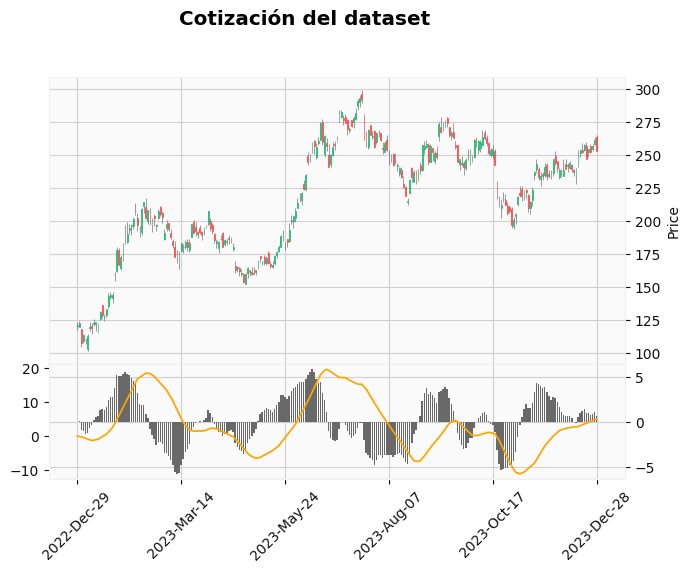

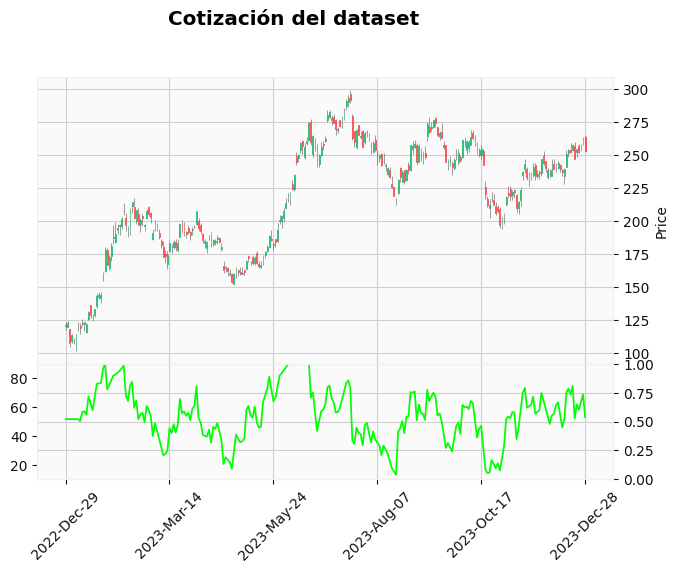

In [93]:
plot_from(tsla, macd=True)
plot_from(tsla, rsi=True)